### Adaptive Formulation for L1 Trend Filter 

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import math
from sklearn.linear_model import LinearRegression
import heapq


In [2]:
def Dmat(n,k):
    """
        function reform a matrix for assets with order
        
        Parameters
        ----------
        n : int
        k: int
        
        Returns
        -------
        D : Array
    """
    if k == 0:
        D = np.eye(n)
    elif k == 1:
        D = np.eye(n-1,n)
        for i in range(n-1):
            D[i, i+1] = -1
    else:
        D = Dmat(n,1)
        for i in range(k-1):
            Dn = Dmat(n-i-1, 1)
            D = np.dot(Dn, D)
    return D

Take an example below , the second order difference operator on a real vector.

To find difference matrix take the following $Dx=\nabla x$

In [3]:
Dmat(10,2)

array([[ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.]])

### L1 Trend Filter


In [4]:
def l1tf(y, lambda_p,k=2):
    
    '''
    y is observed signal, lambda_p is penalization value
    
    
    
    '''
    alpha     = 0.01
    beta      = 0.5
    mu        = 2
    maxiter   = 40
    maxlsiter = 20
    tol       = 1e-4 # tol for duality gap to terminate upon
    
    n = len(y)
    m = n-k
    
    # Difference operators for algorithm
    D = Dmat(n, k) # kth order difference matrix
    DDT = np.dot(D, D.transpose()) 
    
    # initial difference guess
    Dy = np.dot(D, y) 
    
    z = np.zeros((m, 1)) # this is our dual variable 
    mu1 = np.ones((m, 1))
    mu2 = np.ones((m, 1))
    
    t = 1e-10
    pobj = np.inf # primal objective
    dobj = 0 # dual objective
    step = np.inf
    
    # initial values for f1, f2
    f1   =  z-lambda_p
    f2   = -z-lambda_p
    
    for iters in range(maxiter):
        
        # rhs of algorithm to implement 
        DTz = np.dot(z.transpose(), D).transpose()
        DDTz = np.dot(D, DTz)
        w = Dy - (mu1 -mu2)
     
        # how are the two primal objectives equivalent 
        pobj1 = 0.5* np.dot(w.transpose(), (np.dot(np.linalg.inv(DDT), w)))+lambda_p*sum(mu1+mu2)
        pobj2 = 0.5* np.dot(DTz.transpose(),DTz) + lambda_p * sum(abs(Dy-DDTz))
        
       
        pobj = min(pobj1,pobj2)  #sensitive of shaping of arrays
        dobj = -0.5* np.dot(DTz.transpose(), DTz)+ np.dot(Dy.transpose(), z) # dual objective
        
        gap = pobj - dobj #duality gap
        
        if gap <= tol:
            status = "solved"
  
            x = y - np.dot(D.transpose(), z) # solution
            return x, status,gap
        
        # update scheme for the step within primal-dual interior point method , which is a fist order approximation
        # note the step size for the search direction is a function of the residuals for both objectives as the system is coupled 
        if (step >= 0.2):
            t =max(2*m*mu/gap, 1.2*t)
        
        rz = DDTz - w
        S = DDT - np.diag((mu1/f1 + mu2/f2).flatten()) # Jacobian J_1 J_2
        r = -DDTz + Dy + (1/t)/f1 - (1/t)/f2
        dz = np.dot(np.linalg.inv(S), r) # step size for dual variable representing equality 
        
        # step size for the dual variables formulated from constraints 
        dmu1 = -(mu1+((1/t)+dz * mu1)/f1)
        dmu2 = -(mu2+((1/t)-dz * mu2)/f2)
        
        resDual = rz # residual of dual
        resCent = np.vstack((-mu1 * f1-1/t, -mu2 * f2-1/t))
        residual = np.vstack((resDual, resCent))
        
        negIdx1 = (dmu1 < 0)
        negIdx2 = (dmu2 < 0)
        
        
        step = 1
        if negIdx1.any():
            step = min(step, 0.99*min(-mu1[negIdx1]/dmu1[negIdx1]))
        if negIdx2.any():
            step = min(step, 0.99*min(-mu2[negIdx2]/dmu2[negIdx2]))
        
        # Backtracking style line search, parameterized by alpha and beta 
        for liter in range(maxlsiter):
            
            newz    =  z  + step*dz
            newmu1  =  mu1 + step*dmu1
            newmu2  =  mu2 + step*dmu2
            newf1   =  newz - lambda_p
            newf2   = -newz - lambda_p
            
            newResDual  = np.dot(DDT, newz) - Dy + newmu1 - newmu2
            newResCent  = np.vstack((-newmu1*newf1-1/t, -newmu2*newf2-1/t))
            newResidual = np.vstack((newResDual, newResCent))
            
            # break out if actual reduction meets expected via norm of residual
            if max(max(newf1),max(newf2)) < 0 and (np.linalg.norm(newResidual) <= (1-alpha*step)*np.linalg.norm(residual)):
                break
            
            step *= beta
        
        z  = newz
        mu1 = newmu1
        mu2 = newmu2
        f1 = newf1
        f2 = newf2
        
    x = y - np.dot(D.transpose(), z)
    if iters >= maxiter:
        status = 'maxiter exceeded'
        print(status)
        return x, status,None

### Toy Example

In [5]:
def generate_data(x_start=0,x_end=100,n=100,seed=1234,noise=5):
    x=np.linspace(x_start,x_end,n)

    np.random.seed(seed)


    x1=0.5*x[:50]-15+noise*np.random.rand(50)
    x2=-x[50:]+60+noise*np.random.rand(50)


    y=np.concatenate([x1,x2])
    return y

### Performance of Algorithm

In [6]:
y=generate_data()
x_sol,status,gap=l1tf(y.reshape(-1,1),10,k=2)

print(status)
print(f"Duality Gap is {gap}")

solved
Duality Gap is [[9.88880091e-05]]


Text(0.5, 1.0, 'L1 Trend Filtering on toy problem')

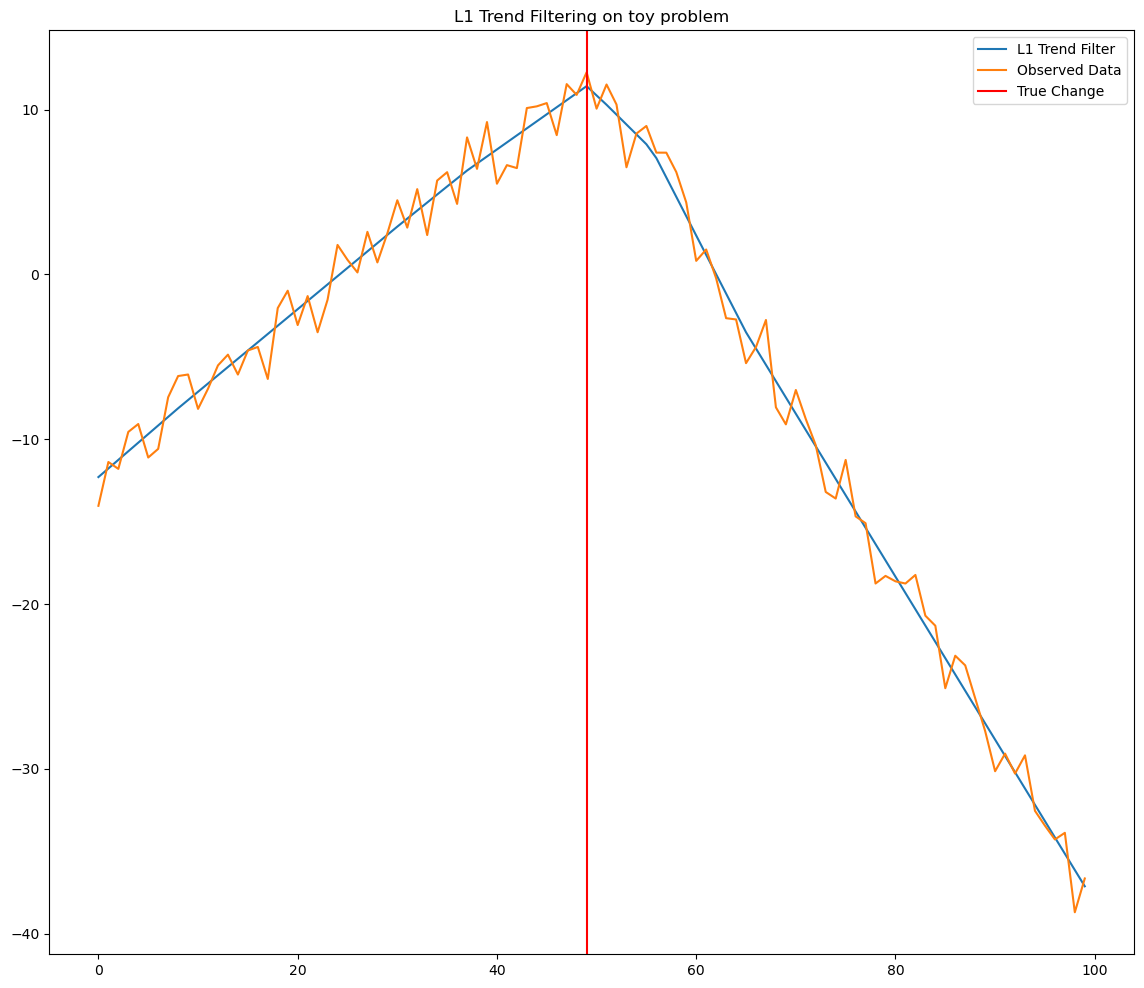

In [7]:
fig,ax=plt.subplots(figsize=(14,12))
ax.plot(x_sol,label= 'L1 Trend Filter')
ax.plot(y, label='Observed Data')
ax.axvline(49,color='red',label='True Change')
ax.legend()

ax.set_title("L1 Trend Filtering on toy problem")

### Formulation of Adaptive Penalization in the Dual Problem

Mathematical Formulation

In [8]:
def l1tf_adaptive(y, lambda_p,k=2):
    
    '''
    y is observed signal, lambda_p is penalization value
    
    
    
    '''
    alpha     = 0.01
    beta      = 0.5
    mu        = 2
    maxiter   = 40
    maxlsiter = 20
    tol       = 1e-4 # tol for duality gap to terminate upon
    
    n = len(y)
    m = n-k
    
    if not isinstance(lambda_p, np.ndarray):
        lambda_p=lambda_p*np.ones((m,1))
     
    
    # Difference operators for algorithm
    D = Dmat(n, k) # kth order difference matrix
    DDT = np.dot(D, D.transpose()) 
    
    # initial difference guess
    Dy = np.dot(D, y) 
    
    z = np.zeros((m, 1)) # this is our dual variable 
    mu1 = np.ones((m, 1))
    mu2 = np.ones((m, 1))
    
    t = 1e-10
    pobj = np.inf # primal objective
    dobj = 0 # dual objective
    step = np.inf
    
    # initial values for f1, f2 , from vector lambda_p
    f1   =  z-lambda_p
    f2   = -z-lambda_p
    
    for iters in range(maxiter):
        
        # rhs of algorithm to implement 
        DTz = np.dot(z.transpose(), D).transpose()
        DDTz = np.dot(D, DTz)
        w = Dy - (mu1 -mu2)
     
        # how are the two primal objectives equivalent 
        pobj1 = 0.5* np.dot(w.transpose(), (np.dot(np.linalg.inv(DDT), w)))+np.sum(np.dot(lambda_p.T,(mu1+mu2)))
        pobj2 = 0.5* np.dot(DTz.transpose(),DTz) + np.sum(np.dot(lambda_p.T, abs(Dy-DDTz)))
        
       
        pobj = min(pobj1,pobj2)  #sensitive of shaping of arrays
        dobj = -0.5* np.dot(DTz.transpose(), DTz)+ np.dot(Dy.transpose(), z) # dual objective
        
        gap = pobj - dobj #duality gap
        
        if gap <= tol:
            status = "solved"
            print(status)
            x = y - np.dot(D.transpose(), z) # solution
            return x, status,gap
        
        # update scheme for the step within primal-dual interior point method , which is a fist order approximation
        # note the step size for the search direction is a function of the residuals for both objectives as the system is coupled 
        if (step >= 0.2):
            t =max(2*m*mu/gap, 1.2*t)
        
        rz = DDTz - w
        S = DDT - np.diag((mu1/f1 + mu2/f2).flatten()) # Jacobian J_1 J_2
        r = -DDTz + Dy + (1/t)/f1 - (1/t)/f2
        dz = np.dot(np.linalg.inv(S), r) # step size for dual variable representing equality 
        
        # step size for the dual variables formulated from constraints 
        dmu1 = -(mu1+((1/t)+dz * mu1)/f1)
        dmu2 = -(mu2+((1/t)-dz * mu2)/f2)
        
        resDual = rz # residual of dual
        resCent = np.vstack((-mu1 * f1-1/t, -mu2 * f2-1/t))
        residual = np.vstack((resDual, resCent))
        
        negIdx1 = (dmu1 < 0)
        negIdx2 = (dmu2 < 0)
        
        
        step = 1
        if negIdx1.any():
            step = min(step, 0.99*min(-mu1[negIdx1]/dmu1[negIdx1]))
        if negIdx2.any():
            step = min(step, 0.99*min(-mu2[negIdx2]/dmu2[negIdx2]))
        
        # Backtracking style line search, parameterized by alpha and beta 
        for liter in range(maxlsiter):
            
            newz    =  z  + step*dz
            newmu1  =  mu1 + step*dmu1
            newmu2  =  mu2 + step*dmu2
            newf1   =  newz - lambda_p
            newf2   = -newz - lambda_p
            
            newResDual  = np.dot(DDT, newz) - Dy + newmu1 - newmu2
            newResCent  = np.vstack((-newmu1*newf1-1/t, -newmu2*newf2-1/t))
            newResidual = np.vstack((newResDual, newResCent))
            
            # break out if actual reduction meets expected via norm of residual
            if max(max(newf1),max(newf2)) < 0 and (np.linalg.norm(newResidual) <= (1-alpha*step)*np.linalg.norm(residual)):
                break
            
            step *= beta
        
        z  = newz
        mu1 = newmu1
        mu2 = newmu2
        f1 = newf1
        f2 = newf2
        
    x = y - np.dot(D.transpose(), z)
    if iters >= maxiter:
        status = 'maxiter exceeded'
        print(status)
        return x, status,None

In [9]:
k=2
pen=10*np.ones(len(y)-k).reshape(-1,1)
x_adapt,status,gap_adapt=l1tf_adaptive(y.reshape(-1,1),pen,k=k)

print(status)
print(f"Duality Gap is {gap}")

solved
solved
Duality Gap is [[9.88880091e-05]]


Text(0.5, 1.0, 'L1 Trend Filtering on toy problem')

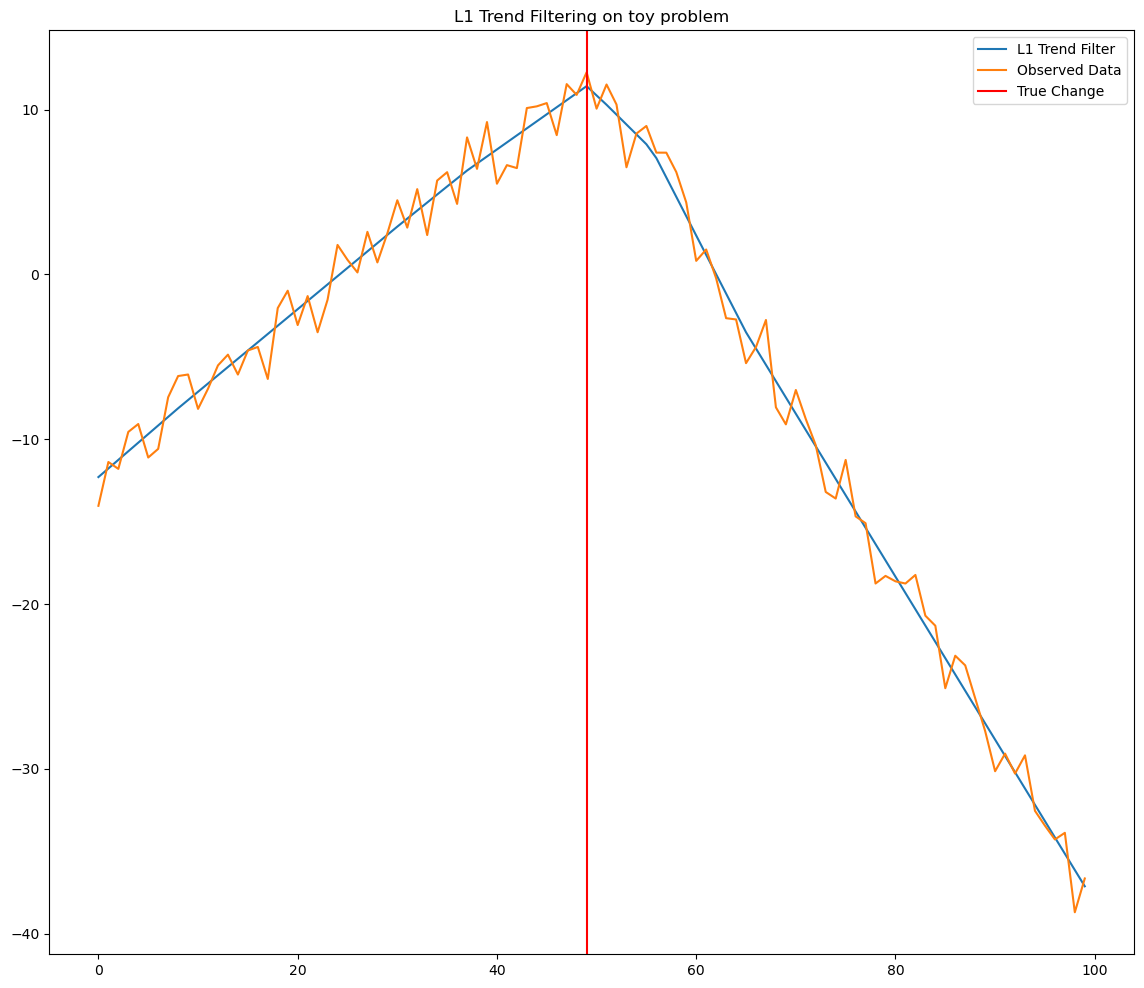

In [30]:
fig,ax=plt.subplots(figsize=(14,12))
ax.plot(x_adapt,label= 'L1 Trend Filter')
ax.plot(y, label='Observed Data')
ax.axvline(49,color='red',label='True Change')
ax.legend()

ax.set_title("L1 Trend Filtering on toy problem")

In [11]:
print(f"Difference in Solutions {np.sum(x_sol-x_adapt)}")
print(f"Difference in Duality Gap {gap-gap_adapt}")

Difference in Solutions 6.439293542825908e-15
Difference in Duality Gap [[-8.52651283e-14]]


### Extreme Cases

When the penalty $\bar{\lambda}$ is no longer uniform across time; there will be a tendency to penalize deviation more severly when $\lambda_t$ are small

Take the above example where there is a simulated changepoint at $x_i=50$ Choosing the penalty to be such we expect the optimization to smooth all points outside of the range around our changepoint

$$ \lambda_t = 
     \begin{cases}
       \text{100} &\quad\text{if t != [49,52]}\\
       \text{0.01} &\quad\text{if t=[49,52]} \\
       \text{0} &\quad\text{if t=0 ,100} \\
     \end{cases}$$


In [78]:
y=generate_data()

k=2
pen=100*np.ones(len(y)-k)
pen[49-(k-1):52-(k-1)]=.01 # indexing starts at 0; note our penalty is len(y)-k 
pen=pen.reshape(-1,1)

x_adapt1,status,gap_adapt=l1tf_adaptive(y.reshape(-1,1),pen,k=k)

print(status)
print(f"Duality Gap is {gap}")

solved
solved
Duality Gap is [[9.88880091e-05]]


Text(0.5, 1.0, 'Penalty Observations')

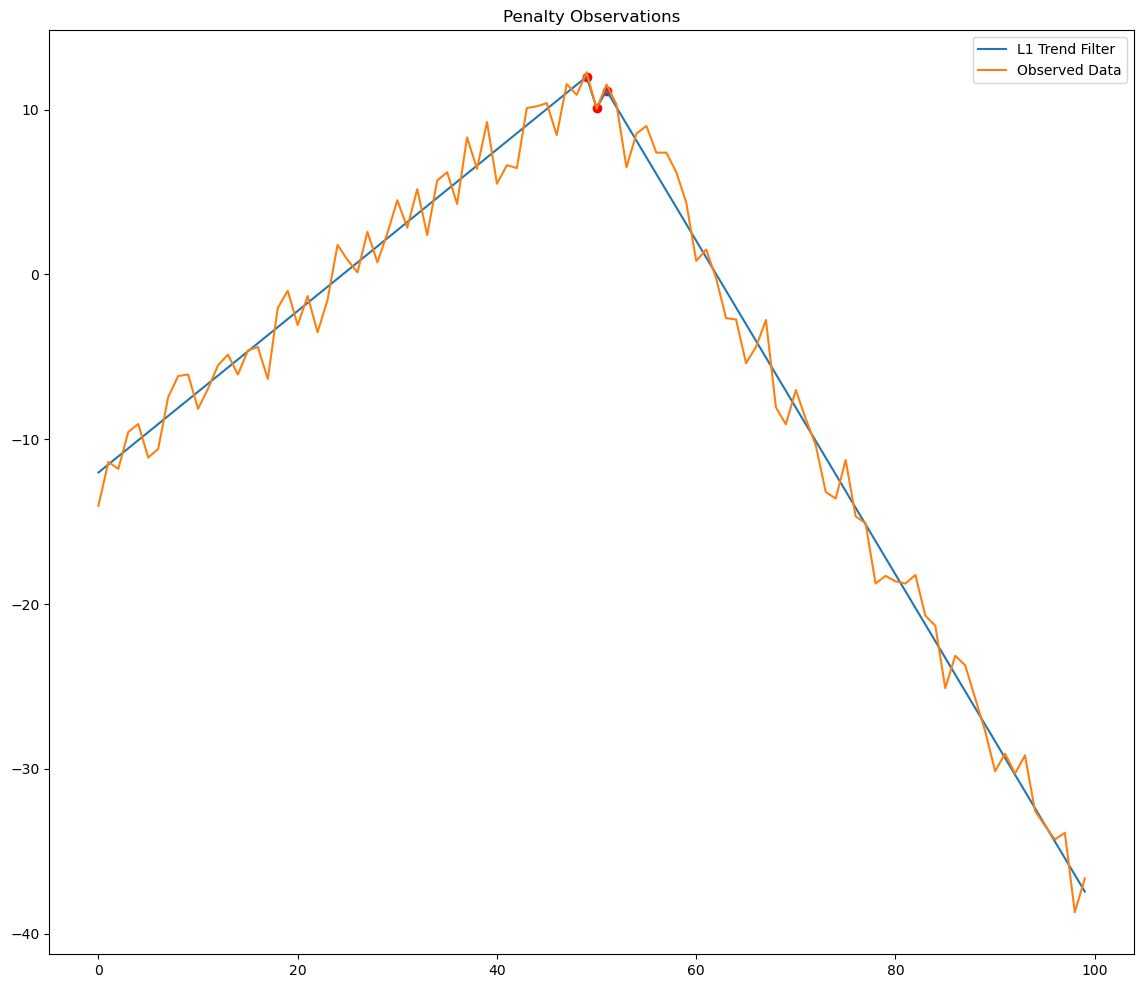

In [80]:
fig,ax=plt.subplots(figsize=(14,12))
ax.plot(x_adapt1,label= 'L1 Trend Filter')
ax.plot(y, label='Observed Data')
plt.scatter([49,50,51],x_adapt1[49:52],color='red')
ax.legend()

ax.set_title("Penalty Observations")

Now let's examine the inverse. Let's use the observed signal $y$; It is visually clear there is a pieceiwse linear change at $t_i$=50

We will loosen the penalty across all values of $t_i$ except for a neighborhood around the value at $t_i=50$. 

$$ \lambda_t = 
   \begin{cases}
       \text{100} &\quad\text{if t = [49,52)}\\
       \text{0.01} &\quad\text{if t != [49,52)} \\
        \text{0} &\quad\text{if t= 0, 100} \\
     \end{cases}
$$

Results:
   - Single penalty points do not seem to effect the l1 trend filtering
   - Larger range of an increased penalty will incentivize continuous l1 trend filtering



In [81]:
y=generate_data(noise=1)


k=2
pen=0.01*np.ones(len(y)-k)
pen[49-(k-1):52-(k-1)]=100# indexing starts at 0; take a +-1 neighborhood around the point
pen=pen.reshape(-1,1)

x_adapt2,status,gap_adapt=l1tf_adaptive(y.reshape(-1,1),pen,k=k)

print(status)
print(f"Duality Gap is {gap}")

solved
solved
Duality Gap is [[9.88880091e-05]]


Text(0.5, 1.0, 'Penalty Observations')

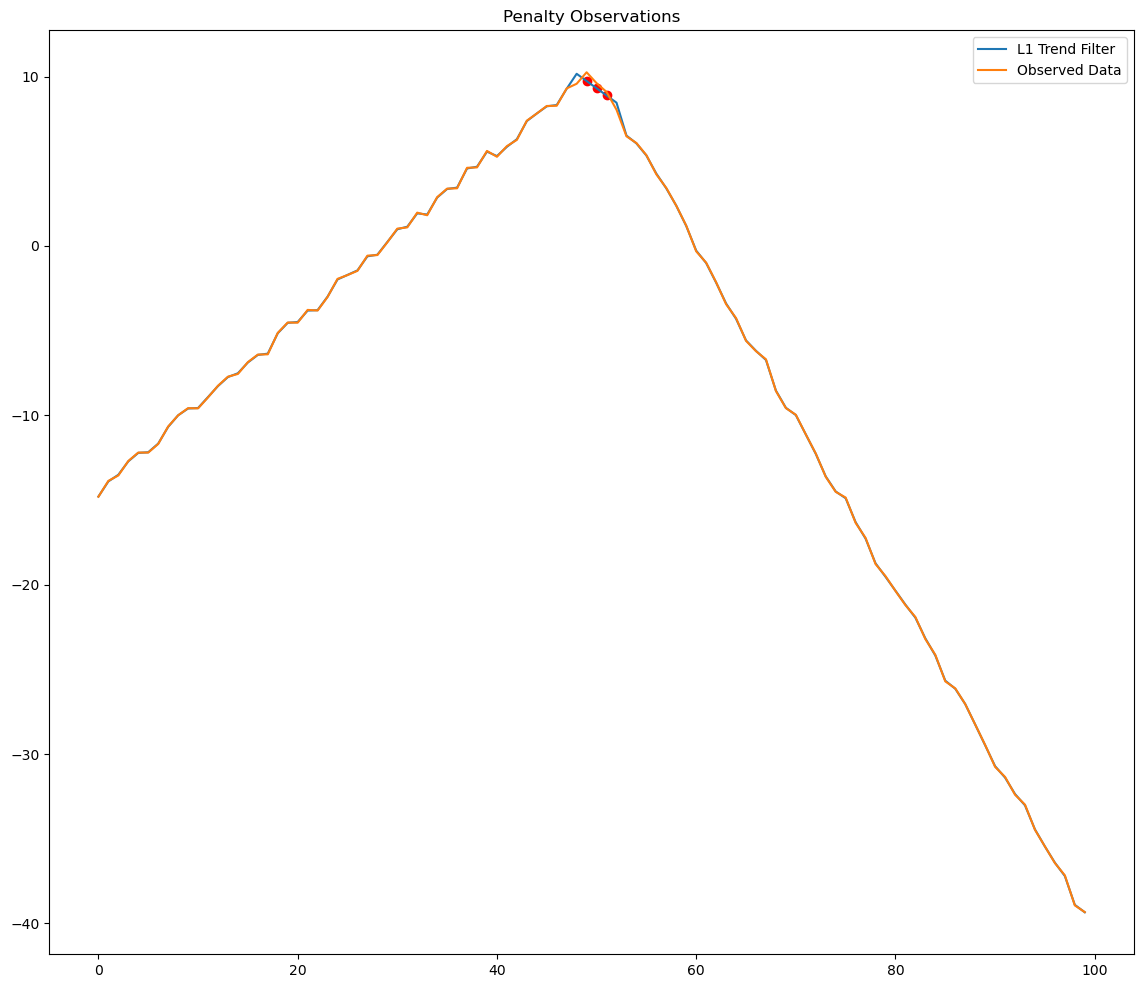

In [83]:
fig,ax=plt.subplots(figsize=(14,12))
ax.plot(x_adapt2,label= 'L1 Trend Filter')
ax.plot(y, label='Observed Data')
ax.legend()
plt.scatter([49,50,51],x_adapt2[49:52],color='red')
ax.set_title("Penalty Observations")